In [13]:
from river import stream,tree,metrics
import utils
import datetime
from encoding import prefix_bin
import csv
import copy
import time
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm

In [14]:
dataset = stream.iter_csv(
            './data/bac_online_small.csv',
            )

totallength = len(list(dataset))

In [15]:
dataset = stream.iter_csv(
            './data/bac_online_small.csv',
            drop=['END_DATE','ROLE','CLOSURE_TYPE','CLOSURE_REASON','WORKING_STATE','case_cost'],
            target='outcome'
            )

In [16]:
key_pair = {
        'REQUEST_ID':'caseid',
        'ACTIVITY':'activity',
        'START_DATE':'ts',
        'CE_UO':'resource'
}

case_dict ={}
training_models ={}
feature_matrix ={}
casecount = 0
rowcounter = 0
resultdict ={}
acc_dict ={}
running_case = 0
prediction_result = {}
graceperiod_finish=0
finishedcases = set()
usedingrace = set()

In [17]:
for x,y in dataset:
    if rowcounter%500 == 0:
        print(round(rowcounter*100/totallength,2) ,'%', 'Case finished: %s'%(casecount))
    rowcounter +=1
    # Event stream change dictionary keys
    x = utils.dictkey_chg(x, key_pair)
#     x['ts'] = x['ts'][:-4]
    # Check label possible
    # x = utils.set_label(x)
    x['outcome'] =y 
    # Initialize case by prefix length
    caseid = x['caseid']
    outcome = x['outcome']
#     progress = x['progress']

    x.pop('caseid')
    x.pop('outcome')
    
#     x.pop('progress')

    case_bin = prefix_bin(caseid, x)

    if caseid not in list(case_dict.keys()):
        case_bin.set_prefix_length(1)    
        case_dict[caseid] = []
    elif caseid in finishedcases:
        pass
    else:
        case_bin.set_prefix_length(len(case_dict[caseid])+1)
        case_bin.set_prev_enc(case_dict[caseid][-1])
    
    # Encode event and cases and add to DB
    case_bin.update_truelabel(outcome)   
    case_bin.update_encoded()
    ts = case_bin.event['ts']
    case_dict[caseid].append(case_bin)
    usedingrace.add(caseid)
    # Detect label appeared case 
    if outcome != '' and caseid not in finishedcases:
        finishedcases.add(caseid)
        # Adding newly finished case to training set.    
        casecount +=1
        # Grace period to collect feature matrix
        if casecount <200:
            case_length = len(case_dict[caseid])
            for prefix in range(1, case_length):
                if 'prefix_%s'%(prefix+1) not in list(feature_matrix.keys()):
                    feature_matrix['prefix_%s'%(prefix+1)]=set()
                    # Initialize classifier and performance matrix and updating count
                    training_models['prefix_%s'%(prefix+1)] = [tree.HoeffdingAdaptiveTreeClassifier(grace_period=100,split_criterion='info_gain'),metrics.Accuracy(), 0,0]
                feature_list = list(case_dict[caseid][prefix].encoded.keys())
                for x in feature_list: feature_matrix['prefix_%s'%(prefix+1)].add(x) 
            graceperiod_finish = case_dict[caseid][-1].event['ts']
            for t in training_models.keys():
                training_models[t][3] = graceperiod_finish
            case_dict.pop(caseid)            
        else:
            break

0.0 % Case finished: 0
0.89 % Case finished: 6
1.79 % Case finished: 7
2.68 % Case finished: 7
3.57 % Case finished: 7
4.46 % Case finished: 7
5.36 % Case finished: 7
6.25 % Case finished: 70
7.14 % Case finished: 94
8.04 % Case finished: 124


In [18]:
maximum_prefix = sorted([int(x.split('_')[1]) for x in training_models.keys()])[-1]

In [19]:
case_dict ={}
for x,y in dataset:
    if rowcounter%500 == 0:
        print(round(rowcounter*100/totallength,2) ,'%', 'Case finished: %s'%(casecount), 'Running case: %s'%(running_case))
    rowcounter +=1
    # Event stream change dictionary keys
    x = utils.dictkey_chg(x, key_pair)
#     x['ts'] = x['ts'][:-4]
    # Check label possible
    # x = utils.set_label(x)
    x['outcome'] =y 
    # Initialize case by prefix length
    caseid = x['caseid']
    outcome = x['outcome']
    x.pop('caseid')
    x.pop('outcome')
    
    if caseid not in usedingrace:
        case_bin = prefix_bin(caseid, x)

        if caseid not in list(case_dict.keys()):
            case_bin.set_prefix_length(1)    
            case_dict[caseid] = []
            running_case +=1
        elif caseid in finishedcases:
            pass
        else:
            case_bin.set_prefix_length(len(case_dict[caseid])+1)
            case_bin.set_prev_enc(case_dict[caseid][-1])

        # Encode event and cases and add to DB
        case_bin.update_truelabel(outcome)   
        case_bin.update_encoded()
        ts = case_bin.event['ts']
        if case_bin.prefix_length >=2 and case_bin.prefix_length <= maximum_prefix:
            case_bin.encoded = utils.readjustment_training(case_bin.encoded, feature_matrix['prefix_%s'%(case_bin.prefix_length)])
            x_test = case_bin.encoded
            model = training_models['prefix_%s'%(case_bin.prefix_length)][0]
            y_pred = model.predict_one(x_test)
            if type(y_pred) != str:
                y_pred = 'False'
            modelid,pred_value = copy.deepcopy(training_models['prefix_%s'%(case_bin.prefix_length)][2]), copy.deepcopy(y_pred)
            case_bin.update_prediction((modelid, (pred_value,ts)))        
        case_dict[caseid].append(case_bin)

        # Detect label appeared case 
        if outcome != '' and caseid not in finishedcases:
            finishedcases.add(caseid)
            # Adding newly finished case to training set.    
            casecount +=1    
            # Real training start

            # Modify encoded attributes of cases with feature matrix
            case_length = len(case_dict[caseid])
            if case_length >maximum_prefix:
                case_length =maximum_prefix
            y = outcome
            for prefix in range(1, case_length):
                case_dict[caseid][prefix].update_truelabel(y)
                x = case_dict[caseid][prefix].encoded
                model = training_models['prefix_%s'%(prefix+1)][0]
                model.learn_one(x,y)
                training_models['prefix_%s'%(prefix+1)][2] +=1
                y_pred = model.predict_one(x)
                training_models['prefix_%s'%(prefix+1)][1].update(y,y_pred)

                for cases in list(case_dict.keys()):
                    if len(case_dict[cases]) >prefix:
                        x_test = case_dict[cases][prefix].encoded
                        y_pred = model.predict_one(x_test)
                        modelid,pred_value = copy.deepcopy(training_models['prefix_%s'%(prefix+1)][2]), copy.deepcopy(y_pred)
                        case_dict[cases][prefix].update_prediction((modelid, (pred_value,ts)))
                        prediction_key = str(cases)+'_'+str(prefix+1)
                        if str(cases)+'_'+str(prefix+2) not in prediction_result.keys():
                            if prediction_key not in prediction_result.keys():
                                prediction_result[prediction_key] = {}
                                prediction_result[prediction_key][modelid] = (pred_value,ts)
                            else:
                                prediction_result[prediction_key][modelid] = (pred_value,ts)
#             print(case_dict[caseid][-2].predicted)
            copying = copy.deepcopy(case_dict[caseid])
            resultdict[caseid] = copying
            case_dict[caseid] =[]
            running_case -=1

            for prefix in training_models.keys():
                if prefix not in list(acc_dict.keys()):
                    acc_dict[prefix]=[training_models[prefix][1].get()]
                else:
                    acc_dict[prefix].append(training_models[prefix][1].get())


8.93 % Case finished: 202 Running case: 50
9.82 % Case finished: 206 Running case: 95
10.71 % Case finished: 222 Running case: 151
11.61 % Case finished: 253 Running case: 190
12.5 % Case finished: 293 Running case: 216
13.39 % Case finished: 343 Running case: 245
14.28 % Case finished: 383 Running case: 273
15.18 % Case finished: 437 Running case: 277
16.07 % Case finished: 483 Running case: 309
16.96 % Case finished: 543 Running case: 318
17.86 % Case finished: 591 Running case: 335
18.75 % Case finished: 702 Running case: 294
19.64 % Case finished: 767 Running case: 339
20.53 % Case finished: 780 Running case: 450
21.43 % Case finished: 798 Running case: 545
22.32 % Case finished: 846 Running case: 608
23.21 % Case finished: 851 Running case: 640
24.11 % Case finished: 866 Running case: 674
25.0 % Case finished: 1048 Running case: 525
25.89 % Case finished: 1159 Running case: 456
26.78 % Case finished: 1263 Running case: 417
27.68 % Case finished: 1334 Running case: 420
28.57 % Case

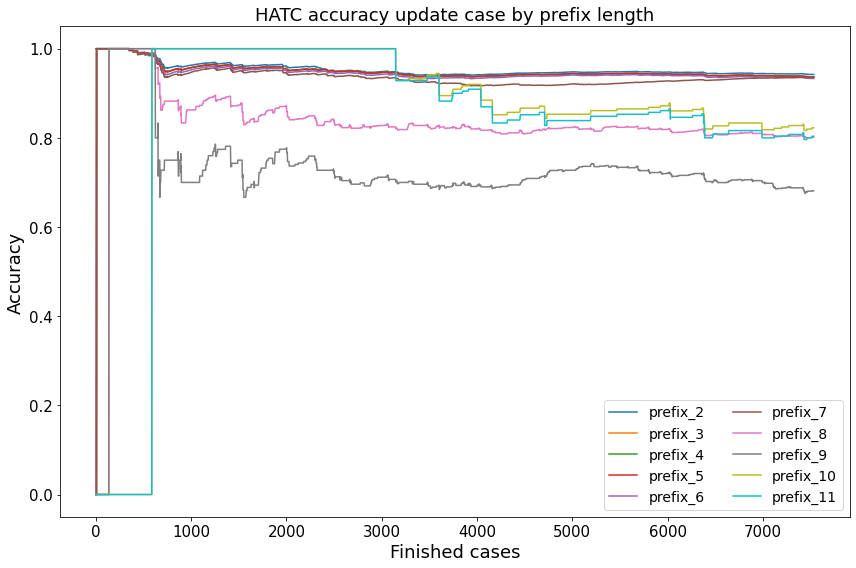

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.rc('axes', titlesize=18) # fontsize of the axes title 
plt.rc('axes', labelsize=18) # fontsize of the x and y labels 
plt.rc('xtick', labelsize=15) # fontsize of the tick labels 
plt.rc('ytick', labelsize=15) # fontsize of the tick labels 
plt.rc('legend', fontsize=14) # legend fontsize 

for t in acc_dict.keys():
    plt.plot(acc_dict[t], label=str(t))
    plt.legend(ncol=2,loc='lower right')
plt.title('HATC accuracy update case by prefix length')
plt.ylabel('Accuracy')
plt.xlabel('Finished cases')
plt.tight_layout()
plt.savefig('./img/hatc_acc_update.png')


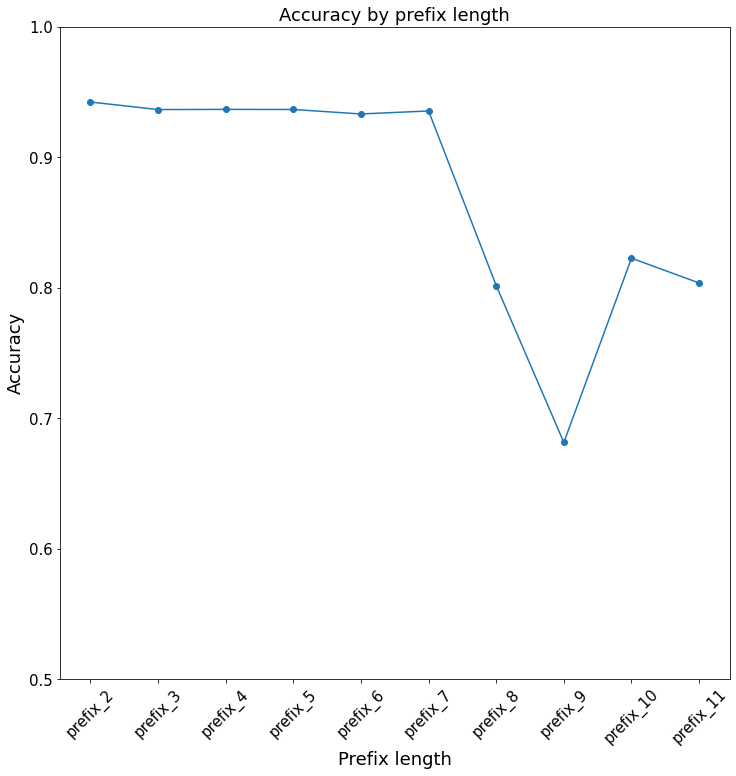

In [38]:
plt.figure(figsize=(12, 12))

plt.rc('axes', titlesize=18) # fontsize of the axes title 
plt.rc('axes', labelsize=18) # fontsize of the x and y labels 
plt.rc('xtick', labelsize=15) # fontsize of the tick labels 
plt.rc('ytick', labelsize=15) # fontsize of the tick labels 
plt.rc('legend', fontsize=14) # legend fontsize 

plt.title('Accuracy by prefix length')
plt.ylabel('Accuracy')
plt.xlabel('Prefix length')
plt.xticks(rotation='45')
axes = plt.gca()
axes.set_ylim([0.5, 1.0])

plt.plot(list(acc_dict.keys()),[acc_dict[x][-1] for x in acc_dict.keys()], '-o')

In [21]:
import numpy as np
from sklearn.metrics import classification_report
for t in range(2,11):
    testcases =[]
    testpred = []
    testtrue = []

    print('prefix_%s'%(t))
    for cases in (np.random.choice(list(resultdict.keys()), 1500)):
        if len(resultdict[cases])>t:
            y_pred = training_models['prefix_%s'%(t+1)][0].predict_one(resultdict[cases][t].encoded)
            testpred.append(y_pred)
            testtrue.append(resultdict[cases][t].true_label)
    metric = metrics.Accuracy()
    cm = metrics.ConfusionMatrix()
    for yt,yp in zip(testtrue,testpred):
        metric = metric.update(yt,yp)
        cm = cm.update(yt,yp)
    print(metric)
    print(cm)
    print(classification_report(testtrue,testpred))

prefix_2
Accuracy: 92.52%
           False    True
   False    1222       1
    True      98       2
              precision    recall  f1-score   support

       False       0.93      1.00      0.96      1223
        True       0.67      0.02      0.04       100

    accuracy                           0.93      1323
   macro avg       0.80      0.51      0.50      1323
weighted avg       0.91      0.93      0.89      1323

prefix_3
Accuracy: 92.98%
           False    True
   False    1245       0
    True      94       0
              precision    recall  f1-score   support

       False       0.93      1.00      0.96      1245
        True       0.00      0.00      0.00        94

    accuracy                           0.93      1339
   macro avg       0.46      0.50      0.48      1339
weighted avg       0.86      0.93      0.90      1339

prefix_4
Accuracy: 94.11%
           False    True
   False    1247       2
    True      76       0
              precision    recall  f1-score

/home/suhwan/.conda/envs/testenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 91.70%
           False    True
   False    1160       0
    True     105       0
              precision    recall  f1-score   support

       False       0.92      1.00      0.96      1160
        True       0.00      0.00      0.00       105

    accuracy                           0.92      1265
   macro avg       0.46      0.50      0.48      1265
weighted avg       0.84      0.92      0.88      1265

prefix_6
Accuracy: 98.14%
           False    True
   False    1042       0
    True      21      64
              precision    recall  f1-score   support

       False       0.98      1.00      0.99      1042
        True       1.00      0.75      0.86        85

    accuracy                           0.98      1127
   macro avg       0.99      0.88      0.92      1127
weighted avg       0.98      0.98      0.98      1127

prefix_7
Accuracy: 66.40%
         False   True
  False     67     39
   True      3     16
              precision    recall  f1-score   support

      

In [22]:
from collections import Counter
def averaged_prediction(bin_result_list):
    return sorted(Counter(bin_result_list).items(),key = (lambda x:x[1]),reverse=True)[0][0]

def get_bin_list(current_event_ts, next_event_ts, bin_n):
    binsize = (next_event_ts -current_event_ts).total_seconds()/bin_n
    binlist= []
    prev_bin=current_event_ts
    for t in range(bin_n):
        binlist.append((prev_bin, prev_bin +datetime.timedelta(seconds=binsize)))
        prev_bin = prev_bin +datetime.timedelta(seconds=binsize)

    return binlist

def averaged_prediction_by_bin(bin_list, event_prediction):
    bin_result_dict = {}
    for pos, t in enumerate(bin_list):
        t = (t[0],t[1],pos+1)
        bin_result_dict[t] = []
    prev_bin_t = list(bin_result_dict.keys())[0]
    for bin_t in bin_result_dict.keys():
        for result in event_prediction.values():
            if result[1] >=  bin_t[0] and result[1] <  bin_t[1]:
                bin_result_dict[bin_t].append(result[0])
            elif bin_t[0]==bin_t[1] and result[1] == bin_t[0]:
                bin_result_dict[bin_t].append(result[0])                       
        if len(bin_result_dict[bin_t]) ==0:
            bin_result_dict[bin_t].append(bin_result_dict[prev_bin_t])
        prev_bin_t = bin_t
        bin_result_dict[bin_t] = averaged_prediction(bin_result_dict[bin_t])
    return bin_result_dict

from sklearn.metrics import classification_report
def continuous_evaluation(resultdict, bin_n):
    bin_pred = {}
    y_true = {}
    counting = 0
    for case in tqdm(resultdict.keys()):
        if len(resultdict[case]) > 2:
            for event in range(1,len(resultdict[case])-1):
                current_event_ts = resultdict[case][event].event['ts']
                next_event_ts = resultdict[case][event+1].event['ts']
                bin_list = get_bin_list(current_event_ts, next_event_ts, bin_n)
                try:
                    t = averaged_prediction_by_bin(bin_list,resultdict[case][event].predicted)
                    y_true[str(case)+'_'+str(event+1)]=resultdict[case][event].true_label
                    bin_pred[str(case)+'_'+str(event+1)]=list(t.values())
                except:
                    pass
    
    return y_true, bin_pred

In [23]:
bin_n = 50

bin_event_acc = {}
y_true, target_pred = continuous_evaluation(resultdict, bin_n)
bin_event_acc = {}

for t in tqdm(range(2,12)):
    bin_y_true = []
    bin_y_pred = []
    if 'prefix_%s'%(t) not in list(bin_event_acc.keys()):
        bin_event_acc['prefix_%s'%(t)]=[]
    for prefix in y_true.keys():
        if t ==int(prefix.split('_')[1]):
            bin_y_true.append(y_true[prefix])
            bin_y_pred.append(target_pred[prefix])
#     print(bin_y_pred)
    for bin_interval in range(bin_n):
        bin_y_pred2 = [x[bin_interval] for x in bin_y_pred]
        bin_event_acc['prefix_%s'%(t)].append(accuracy_score(bin_y_true, bin_y_pred2))

100%|██████████| 10/10 [00:01<00:00,  5.93it/s]


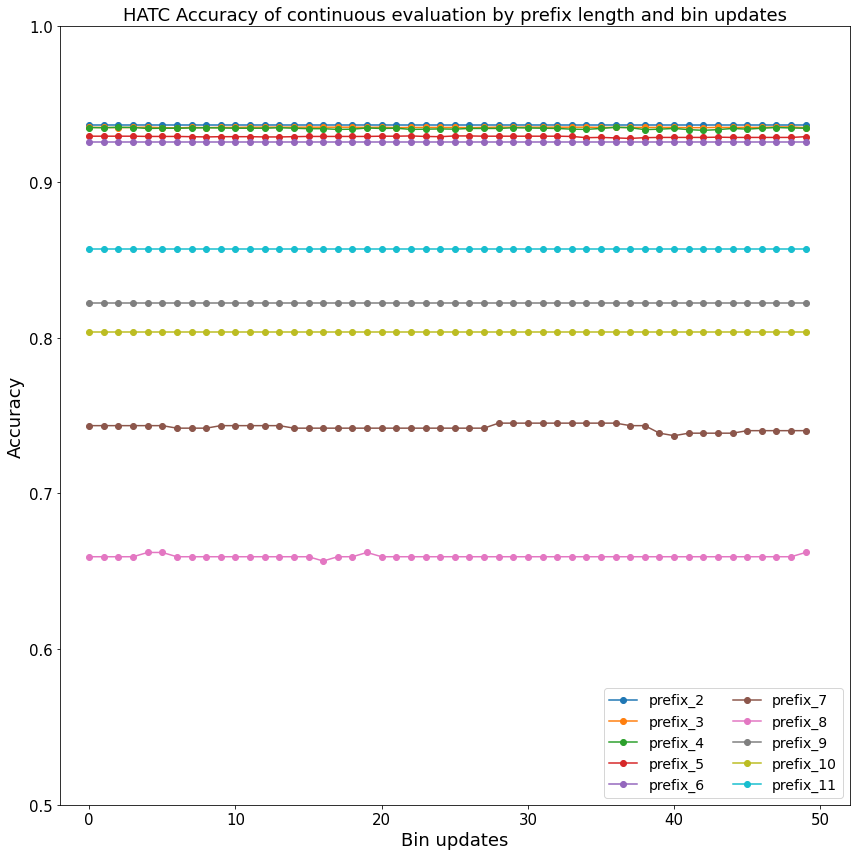

In [63]:
plt.figure(figsize=(12, 12))

plt.rc('axes', titlesize=18) # fontsize of the axes title 
plt.rc('axes', labelsize=18) # fontsize of the x and y labels 
plt.rc('xtick', labelsize=15) # fontsize of the tick labels 
plt.rc('ytick', labelsize=15) # fontsize of the tick labels 
plt.rc('legend', fontsize=14) # legend fontsize 


for t in bin_event_acc.keys():
    plt.plot(bin_event_acc[t],'-o',label=t)
    plt.legend(ncol=2,loc='lower right')
plt.title('HATC Accuracy of continuous evaluation by prefix length and bin updates')
plt.ylabel('Accuracy')
plt.xlabel('Bin updates')
plt.axis([-2, 52, 0.5, 1.0])
plt.tight_layout()

plt.savefig('./img/HATC continuous acc.png')

In [53]:
import pickle as pkl
uio = []
for t in acc_dict.keys():
    uio.append(t)
y = [acc_dict[x][-1] for x in acc_dict.keys()]
with open('./result/hatc_lastacc.pkl','wb') as f:
    pkl.dump([uio,y],f)

dict_keys(['prefix_2', 'prefix_3', 'prefix_4', 'prefix_5', 'prefix_6', 'prefix_7', 'prefix_8', 'prefix_9', 'prefix_10', 'prefix_11'])
